# Correcting absolute hydration free energies using deep neural networks

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Model-hyper-parameter-statistics" data-toc-modified-id="Model-hyper-parameter-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model hyper-parameter statistics</a></span></li><li><span><a href="#Propagation-of-errors" data-toc-modified-id="Propagation-of-errors-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Propagation of errors</a></span></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Load-testing-data" data-toc-modified-id="Load-testing-data-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Load testing data</a></span></li><li><span><a href="#Original-$\Delta-G_{hydr}$" data-toc-modified-id="Original-$\Delta-G_{hydr}$-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Original $\Delta G_{hydr}$</a></span></li><li><span><a href="#Predict-$\Delta-G_{offset}$" data-toc-modified-id="Predict-$\Delta-G_{offset}$-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Predict $\Delta G_{offset}$</a></span></li><li><span><a href="#$\Delta-G_{hydr}$-correction" data-toc-modified-id="$\Delta-G_{hydr}$-correction-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>$\Delta G_{hydr}$ correction</a></span></li></ul></li><li><span><a href="#Removing-possible-outlier" data-toc-modified-id="Removing-possible-outlier-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Removing possible outlier</a></span></li><li><span><a href="#Recreating-SAMPL4-Figure-1" data-toc-modified-id="Recreating-SAMPL4-Figure-1-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Recreating SAMPL4 Figure 1</a></span></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import shutil
import logging
import pickle
from tqdm import tqdm_notebook as tqdm

# Statistics:
import scipy
import statistics
from sklearn.metrics import r2_score

# Tensorflow:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump, load
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Statistics:
import scipy
from uncertainties import unumpy
import itertools
itertools.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Path variables

In [2]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output/'
figures_dr = path + 'figures/'
freesolv_loc = datasets_dr + 'freesolv_database.txt'

## Global variables

In [3]:
# Global variables:
model_type = 'DNN'
label_col = 'dGoffset (kcal/mol)'

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed

# DNN global variables
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

# load in data set
dtrain_df = pd.read_hdf(datasets_dr + 'dtrain_data.h5', key='relative')
num_input_nodes = len(dtrain_df.columns) - 1

In [4]:
figsize = [8, 6]
fontsize = 18
markersize = 20
linewidth = 2
dGhydr_xlim = [-25.0, 2.5]
dGhydr_ylim = [-25.0, 2.5]
colour1 = 'darkgray'
colour2 = 'green'
colour3 = 'lightsteelblue'
colour4 = 'palegreen'

## Load data

In [5]:
# gp_minimize object
gp_results = [load(output_dr + 'fold_' + str(fold_num) +  '_gp_minimize_result.pickle') 
                 for fold_num in range(1, n_splits + 1)]

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Model hyper-parameter statistics

In [6]:
def mae_convergence(dataframe):

    # x values
    x = np.linspace(1, n_calls, n_calls)

    # y values
    mae = [dataframe.loc[dataframe.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
           for fold in range(1, n_splits + 1)]
    cumm_mae = list(zip(*mae))
    y = [statistics.mean(call) for call in cumm_mae]

    # standard devation
    std = [statistics.stdev(call) for call in cumm_mae]

    # standard devation bounds
    y1 = [i - sd for i, sd in zip(y, std)]
    y2 = [i + sd for i, sd in zip(y, std)]

    # plot mean line
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)

    ax.plot(x, y,
            color=colour2,
            linewidth=linewidth,
            label='Average MAE over {} folds'.format(n_splits))

    # plot standard deviation fill bounds
    ax.fill_between(x, y1, y2,
                    fc=colour3,
                    ec=colour3,
                    label='Standard deviation')

    ax.set_xlabel('Number of calls $n$', fontsize=fontsize)
    ax.set_ylabel('MAE / kcal mol$^{-1}$', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.legend(fontsize=fontsize)
    plt.tight_layout()
    
    fig.savefig(figures_dr + 'convergence_plot.png')
    
    return ax

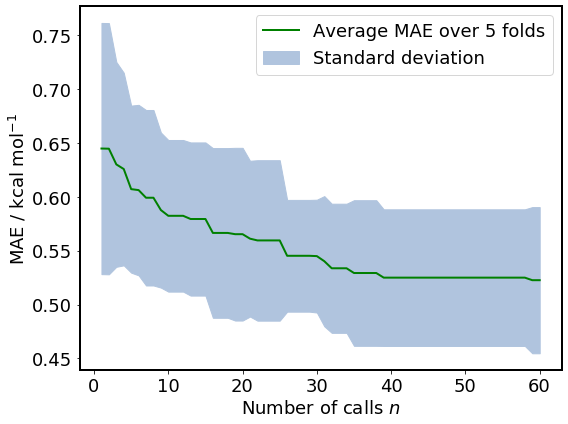

In [7]:
mae_logger = [[fold_num + 1, x] for fold_num, result in enumerate(gp_results) for x in result['func_vals']]
mae_df = pd.DataFrame(mae_logger, columns=['Fold', 'MAE (kcal/mol)'])
mae_convergence(mae_df)  # Plot convergence plot.

## Propagation of errors

In [8]:
def calc_mae(x, y):
    """Returns list of mean absolute error between two lists.
    Assumes len(x) == len(y)."""
    ae = [abs(i - j) for i, j in zip(x, y)]
    return sum(ae) / len(ae)

In [9]:
def calc_pearson_r(x, y):
    """
    Calculates Pearson R value.
    Assumes len(x) == len(y).
    Parameters
    ----------
    x: array like of uncertainties.core.Variable
    y: array like of uncertainties.core.Variable
    ----------
    Returns array like of uncertainties.core.Variable
    """
    n = len(x)  # number of samples
    try:
        x_norm = [i.n for i in x]  # x without uncertainty
        y_norm = [i.n for i in y]  # y without uncertainty
    except AttributeError:
        x_norm = x
        y_norm = y
    sum_x = float(sum(x_norm))  # sum of x
    sum_y = float(sum(y_norm))  # sum of y
    sum_x_sq = sum(itertools.imap(lambda x: pow(x, 2), x))  # sum of x**2
    sum_y_sq = sum(itertools.imap(lambda x: pow(x, 2), y))  # sum of y**2
    psum = sum(itertools.imap(lambda x, y: x * y, x, y))  # sum of x*y
    num = psum - (sum_x * sum_y/n)  # Pearson R equation numerator
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)  # Pearson R formular demoninator
    if den == 0: return 0  # Prevent division by zero
    return num / den

In [10]:
def sum_error(error1, error2):
    """Returns sum propagated error between two int or floats."""
    return (error1 ** 2 + error2 ** 2) ** 0.5

In [11]:
def avg_err(x, y):
    """Returns an averaged error between two lists.
    Assumes len(x) == len(y)."""
    err = [i - j for i, j in zip(x, y)]
    return sum(err) / len(err)

In [12]:
def rmse(x, y):
    """Returns the root means squared error of two lists.
    Assumes len(x) == len(y)"""
    num = sum([(i - j)**2 for i, j in zip(x, y)])
    den = len(x)
    return (num / den)**0.5

In [13]:
def kendall_tau(x, y):
    tau, p_value = scipy.stats.kendalltau(x, y)
    return tau

## External testing

In [14]:
def plot_scatter(calc, exp, title, x_label, y_label, colour):
    """
    Returns and saves linear regression scatter plot.
    Note: takes pre-defined global variables: figsize, linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # Unpack data.
    x = calc.iloc[:,0]
    y = exp.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)  # Frame line width.
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    ax.set_xlabel(x_label, fontsize=fontsize)  # X-axis label font size.
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label font size.
    ax.set_xlim(dGhydr_xlim)  # X-axis range.
    ax.set_ylim(dGhydr_ylim)  # Y-axis range.
    
    # Plot scatter.
    ax.scatter(x, y, color=colour, s=markersize)

    # Plot line of best fit.
    ax.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=linewidth)

    # Create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(calc.iloc[:,0], calc.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # Calculate mean absolute error.
    mae = calc_mae(xu, yu)
    
    # Calculate Pearson R.
    r_value = calc_pearson_r(xu, yu)

    # Annotate with mean absolute error and Pearson R.
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', '$\pm$')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)

    # Save figure using the title as filename.
    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

### Load testing data

In [15]:
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python').rename(columns={'compound id (and file prefix)': 'ID'})
freesolv_df = freesolv_df.set_index('ID').sort_index()

In [16]:
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)']].sort_index()
test_fep = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['Mobley group calculated value (GAFF) (kcal/mol)', 'calculated uncertainty (kcal/mol)']].sort_index()
test_X = pd.read_csv(datasets_dr + 'test_data.csv', index_col='ID').iloc[:,:-2].sort_index()
test_y = pd.read_csv(datasets_dr + 'test_data.csv', index_col='ID').iloc[:,-2:].sort_index()
test_ID = test_y.index

### Original $\Delta G_{hydr}$

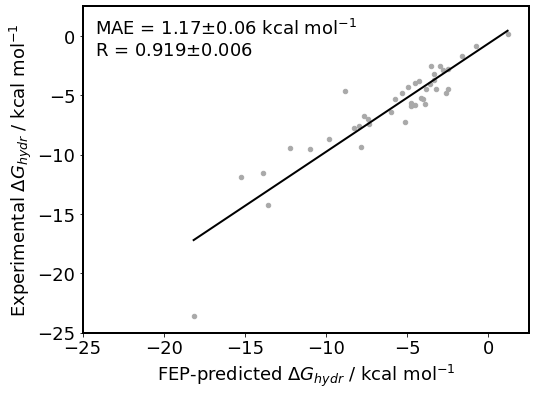

In [17]:
plot_scatter(calc=test_fep,
             exp=test_exp,
             title='Original test set hydraton free energy',
             x_label='FEP-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

### Predict $\Delta G_{offset}$

In [18]:
def model_predict(model_num, test_entry):
    """Load model from HDF5 and return model prediction on a given test_entry."""

    model = tf.keras.models.load_model(output_dr + 'ddGhydr_' + model_type + '_fold_' + str(model_num) + '_model.h5')

    return model.predict(test_entry)

In [19]:
predict_per_fold = [model_predict(fold_num, test_X.to_numpy()) for fold_num in range(1, n_splits + 1)]
predict_per_fold = [np.asarray([x[0] for x in fold.tolist()]) for fold in predict_per_fold]
predicted_y = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in np.average(predict_per_fold, axis=0)],
                                      'Standard deviation (kcal/mol)': np.std(predict_per_fold, axis=0)},
                           index=test_ID)

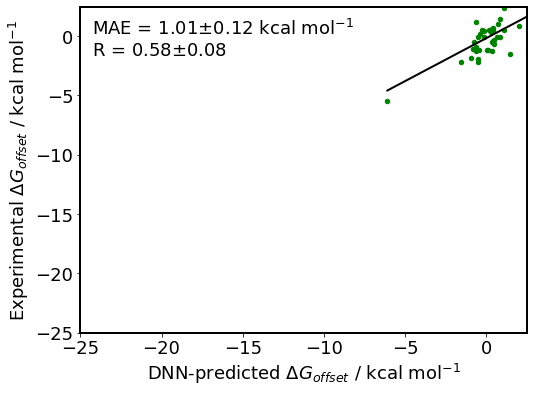

In [20]:
plot_scatter(calc=predicted_y,
             exp=test_y,
             title='DNN-predicted test set offsets',
             x_label='DNN-predicted $\Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{offset}$ / kcal mol$^{-1}$',
             colour=colour2)

### $\Delta G_{hydr}$ correction

In [21]:
test_corr = pd.DataFrame(data={'FEP+ML dGoffset (kcal/mol)': [fep + offset for fep, offset in zip(test_fep.iloc[:,0], predicted_y.iloc[:,0])],
                               'uncertainty (kcal/mol)': [sum_error(x, y) for x, y in zip(predicted_y.iloc[:,1], test_fep.iloc[:,1])]},
                         index=test_ID)

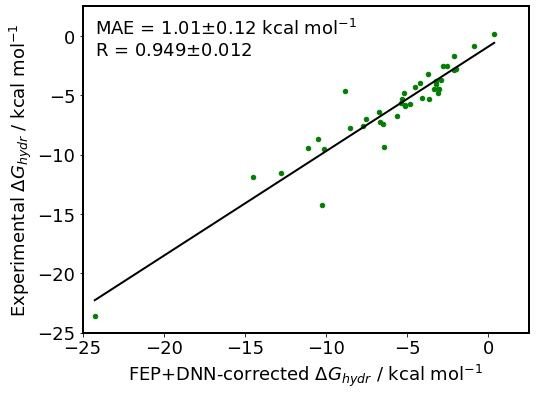

In [22]:
plot_scatter(calc=test_corr,
             exp=test_exp,
             title='FEP+DNN corrected test set hydraton free energy',
             x_label='FEP+DNN-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

In [23]:
def plot_scatter_with_arrows(calc, exp, offsets, corr):
    """
    Returns and saves several overlayed plots:
    1. Uncorrected scatter plot between calculated and experiemntal values.
    2. Corrected scatter plot between corrections and experiemntal values.
    3. Line of best fit for the aforementioned corrected scatter plot.
    4. Arrows in the form of annotations between respective uncorrected and corrected scatter points.
    Note: takes pre-defined global variables: linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    ----------
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    offsets: (DataFrame) predicted offsets at column index 0 with associated errors at column index 1.
    corr: (DataFrame) corrected calculated data at column index 0 with associated errors at column index 1.
    """
    
    # Unpack data.
    x_fep = calc.iloc[:,0]
    x_ml = corr.iloc[:,0]
    y = exp.iloc[:,0]
    offset = offsets.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=[15,10])
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('Predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_ylabel('Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_xlim(dGhydr_xlim)
    ax.set_ylim(dGhydr_ylim)
    
    # Plot FEP vs exp and FEP+ML vs exp.
    ax.scatter(x_fep, y, color=colour1, s=markersize, label='FEP')
    ax.scatter(x_ml, y, color=colour2, s=markersize, label='FEP+DNN')
    
    # Plot line of best fit.
    ax.plot(np.unique(x_ml),
         np.poly1d(np.polyfit(x_ml, y, 1))(np.unique(x_ml)),
         color='black', linewidth=linewidth)
    
    # Annotate with arrows.
    for o, f, e in zip(offset, x_fep, y):
        fep_corrected = f + o
        fep_offset = e - f
        fep_corrected_offset = e - fep_corrected
        
        if abs(fep_corrected_offset) <= abs(fep_offset):
            line_color = "green"
        else:
            line_color = "red"
            
        ax.annotate("", xytext=(f, e), xy=(fep_corrected, e), 
                     arrowprops=dict(arrowstyle="->", color=line_color))

    # create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # mean absolute error
    mae = calc_mae(xu, yu)
    
    # Pearson R and R-squared
    r_value = calc_pearson_r(xu, yu)

    # annotate with r-squared and MAE
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', '$\pm$')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)

    # Create legend.
    plt.legend(loc='lower right', fontsize=fontsize)
    
    # Save figure.
    filename = figures_dr + 'offset_mapping.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

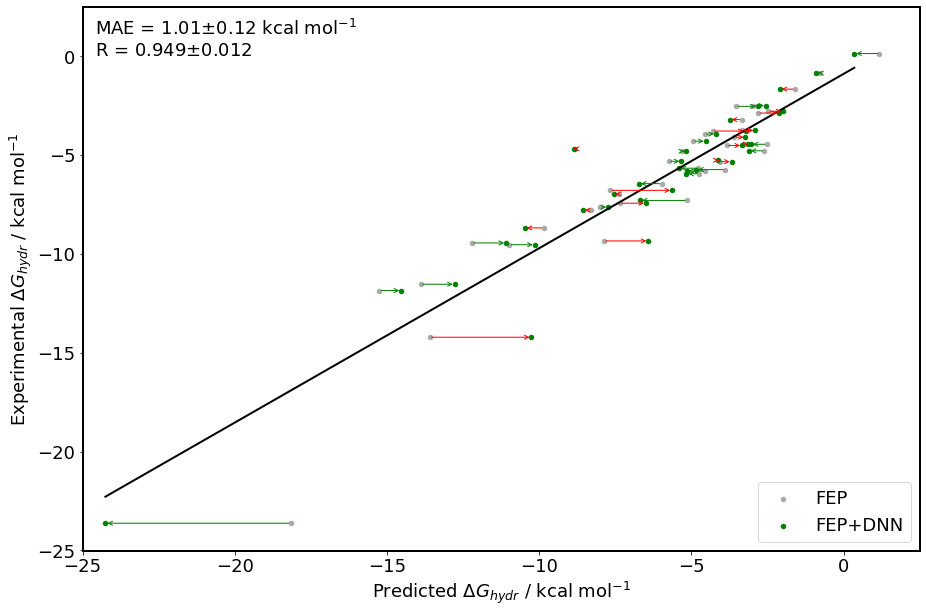

In [24]:
plot_scatter_with_arrows(calc=test_fep,
                         exp=test_exp,
                         offsets=predicted_y,
                         corr=test_corr)

## Removing possible outlier

In [25]:
outlier = 'mobley_4587267'

In [26]:
# Remove outlier from all pre-defined DataFrames.
test_ID_o = test_ID.drop(outlier)
test_X_o = test_X.iloc[test_X.index != outlier, :]
test_y_o = test_y.iloc[test_y.index != outlier, :]
test_fep_o = test_fep.iloc[test_fep.index != outlier, :]
test_exp_o = test_exp.iloc[test_exp.index != outlier, :]

# Perform new offset predictions.
predict_per_fold_o = [model_predict(fold_num, test_X_o.to_numpy()) for fold_num in range(1, n_splits + 1)]
predict_per_fold_o = [np.asarray([x[0] for x in fold.tolist()]) for fold in predict_per_fold_o]
predicted_y_o = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in np.average(predict_per_fold_o, axis=0)],
                                      'Standard deviation (kcal/mol)': np.std(predict_per_fold_o, axis=0)},
                           index=test_ID_o)

test_corr_o = pd.DataFrame(data={'FEP+ML dGoffset (kcal/mol)': [fep + offset for fep, offset in zip(test_fep_o.iloc[:,0], predicted_y_o.iloc[:,0])],
                               'uncertainty (kcal/mol)': [sum_error(x, y) for x, y in zip(predicted_y_o.iloc[:,1], test_fep_o.iloc[:,1])]},
                         index=test_ID_o)

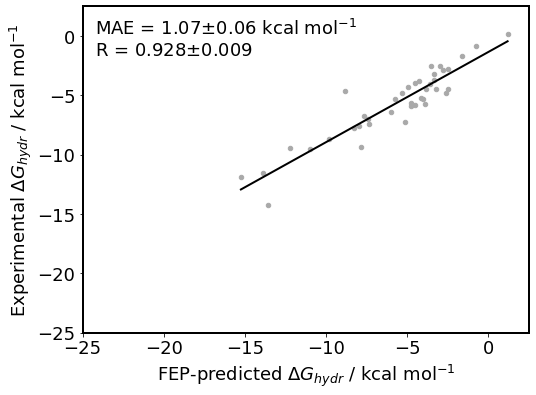

In [27]:
plot_scatter(calc=test_fep_o,
             exp=test_exp_o,
             title='Original test set hydraton free energy with removed outlier',
             x_label='FEP-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

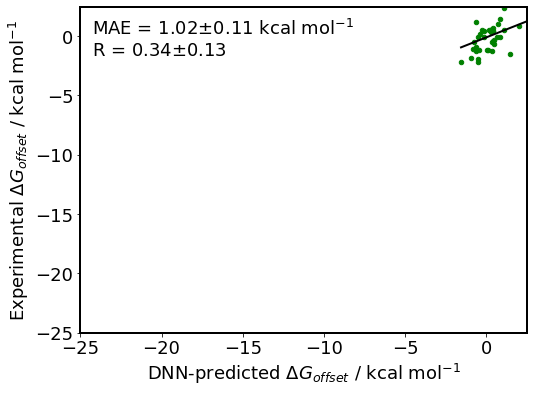

In [28]:
plot_scatter(calc=predicted_y_o,
             exp=test_y_o,
             title='DNN-predicted test set offsets with removed outlier',
             x_label='DNN-predicted $\Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{offset}$ / kcal mol$^{-1}$',
             colour=colour2)

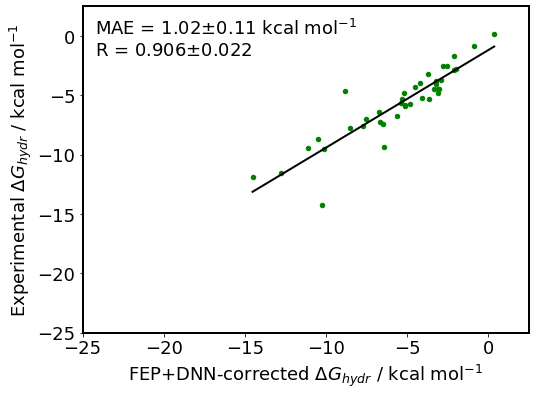

In [29]:
plot_scatter(calc=test_corr_o,
             exp=test_exp_o,
             title='FEP+DNN corrected test set hydraton free energy with outlier removed',
             x_label='FEP+DNN-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

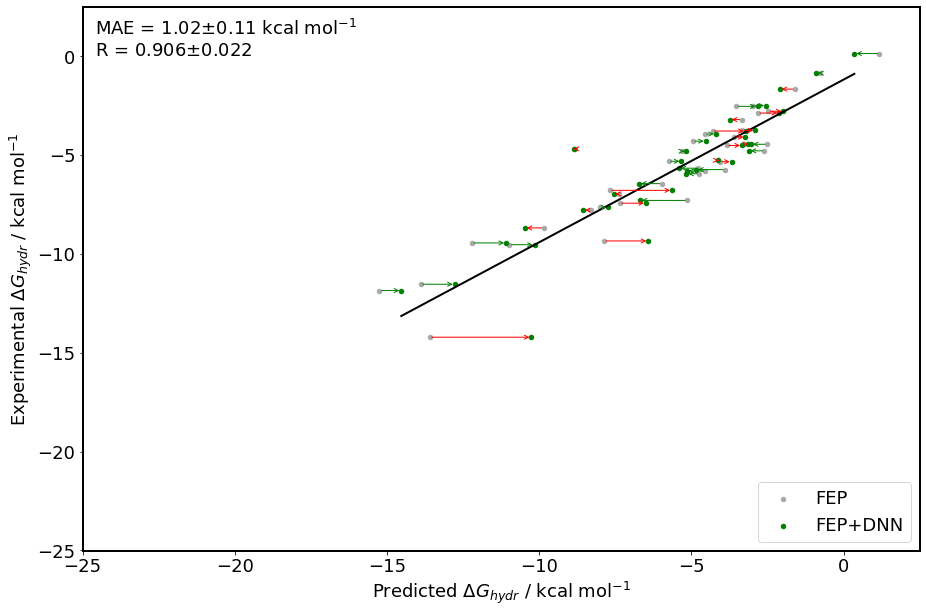

In [30]:
plot_scatter_with_arrows(calc=test_fep_o,
                         exp=test_exp_o,
                         offsets=predicted_y_o,
                         corr=test_corr_o)

## Recreating SAMPL4 Figure 1

In [31]:
sampl4_table3 = pd.read_csv(datasets_dr + 'SAMPL4_table_3.csv', dtype={'ID':str})
sampl4_table3 = sampl4_table3.set_index('ID')
sampl4_table3

,Avg. err.,error,RMS,error1,AUE,error2,tau,error3,R,error4,Err. slope,error5,Max. err.,error6
ID,,,,,,,,,,,,,,
004,0.13,0.13,1.40,0.12,1.10,0.10,0.73,0.06,0.93,0.02,0.99,0.07,4.98,0.47
005,-0.42,0.18,1.22,0.15,0.96,0.12,0.78,0.06,0.96,0.01,1.06,0.05,1.81,0.67
014,1.11,0.57,3.07,0.72,1.90,0.51,0.36,0.15,0.71,0.26,1.01,0.10,10.69,0.70
015,1.02,0.49,3.09,0.46,2.02,0.34,0.36,0.09,0.65,0.20,1.00,0.07,10.37,0.42
137,2.24,0.23,2.89,0.30,2.48,0.20,0.70,0.06,0.89,0.03,0.70,0.08,8.38,0.50
138,0.51,0.29,2.00,0.23,1.66,0.20,0.65,0.06,0.90,0.05,0.57,0.08,5.25,0.23
141,-0.07,0.28,1.46,0.18,1.07,0.11,0.74,0.07,0.93,0.02,0.72,0.08,6.02,0.46
145,-0.44,0.16,1.23,0.16,0.87,0.09,0.81,0.03,0.98,0.01,0.86,0.08,1.24,0.89
149,0.03,0.24,1.46,0.14,1.12,0.12,0.73,0.05,0.94,0.02,0.55,0.04,2.74,0.89


In [32]:
def new_sampl4_row(corr, exp, index):
    
    # Unpack data.
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    avg_error = str(avg_err(xu, yu)).split('+/-')
    rms = str(rmse(xu, yu)).split('+/-')
    aue = str(calc_mae(xu, yu)).split('+/-')
    tau = kendall_tau(xu, yu)
    r = str(calc_pearson_r(xu, yu)).split('+/-')
    
    new_row = pd.DataFrame(data={'Avg. err.': float(avg_error[0]),
                                 'error': float(avg_error[1]),
                                 'RMS': float(rms[0]),
                                 'error1': float(rms[1]),
                                 'AUE': float(aue[0]),
                                 'error2': float(aue[1]),
                                 'tau': tau,
                                 'error3': 0.0,
                                 'R': float(r[0]),
                                 'error4': float(r[1]),
                                 'Err. slope': 0.0,
                                 'error5': 0.0,
                                 'Max. err.': 0.0,
                                 'error6': 0.0},
                           index=[index])
    
    return new_row

In [33]:
fep_ml_df = new_sampl4_row(corr=test_corr, exp=test_exp, index='FEP+ML')
dnn_df = new_sampl4_row(corr=predicted_y, exp=test_exp, index='ML')
null_predicted_y = pd.read_csv('./output_null/null_predicted_dGhydr_DNN.csv', index_col='ID')
null_dnn_df = new_sampl4_row(corr=null_predicted_y, exp=test_exp, index='ML')

In [34]:
def plot_sampl4_bar(*args):
    
    # Setup figure.
    fig, ax = plt.subplots(1, 2, figsize=[16, 6])
    for i in [0, 1]:
        for axis in ['top','bottom','left','right']: ax[i].spines[axis].set_linewidth(linewidth)  # Frame line width.
        ax[i].tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    
    # Read in original SAMPL4 Table 3 and retain index column values as strings.
    sampl4_df = pd.read_csv(datasets_dr + 'SAMPL4_table_3.csv', dtype={'ID':str})
    sampl4_df = sampl4_df.set_index('ID')
    
    # Determine whether to append new data to existing DataFrame.
    figure_num = 1
    for arg in args:
        sampl4_df = sampl4_df.append(arg, sort=False)
        figure_num += 1
    
    # Dictionary of metrics to plot as keys and respective column index locations in SAMPL4_df as values.
    metric_dict = {'MAE': 4, 'Pearson R': 8}
    
    # Loop through each metric and plot ax.
    for i, metric in zip([0, 1], metric_dict):
        # Locate metric and respective uncertainties columns.
        metric_df = sampl4_df.iloc[:, [metric_dict[metric], metric_dict[metric] + 1]]
        # Sort DataFrame accroding to metric column.
        metric_df = metric_df.sort_values(by=metric_df.columns[0])
        
        # Reverse DataFrame if plotting Pearson R only.
        if metric == 'MAE': pass
        elif metric == 'Pearson R': metric_df = metric_df.iloc[::-1]

        # # Uncomment if avg. err. was added to metric_dict.
        # if metric == 'MAE':
        #     metric_df = metric_df.iloc[metric_df.abs().argsort()]
        # elif metric == 'Pearson R':
        #     metric_df = metric_df.iloc[metric_df.abs().argsort()].iloc[::-1]
        
        # Only plot the two twenty submissions.
        metric_df = metric_df.head(20)
        
        # Locate FEP, ML and FEP+ML submissions where applicable.
        metric_fep = metric_df.loc['004',metric_df.columns[0]]
        try: metric_ml = metric_df.loc['ML']
        except KeyError: pass
        try: metric_fep_ml = metric_df.loc['FEP+ML']
        except KeyError: pass
        
        # Plot bar graphs of all subissions, FEP, ML and FEP+ML where applicable.
        ax[i].bar(metric_df.index, metric_df.iloc[:,0], yerr=metric_df.iloc[:,1],color=colour3, label='Other submissions')
        ax[i].bar('004', metric_fep, color=colour1, label='FEP')
        try: ax[i].bar('ML', metric_ml, color=colour4, label='ML')
        except NameError: pass
        try: ax[i].bar('FEP+ML', metric_fep_ml, color=colour2, label='FEP+ML')
        except NameError: pass
        
        # Axes formatting.
        ax[i].set_title(metric, fontsize=fontsize)
        ax[i].set_ylabel('{} / kcal mol{}'.format(metric, '$^{-1}$'), fontsize=fontsize)
        for tick in ax[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
            tick.label.set_rotation('vertical')
        handles, labels = ax[i].get_legend_handles_labels()
        fig.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.15, 0.55), ncol=1)

    plt.tight_layout()
    plt.savefig(figures_dr + model_type + '_' + str(figure_num) + '_SAMPL4_panel.png')

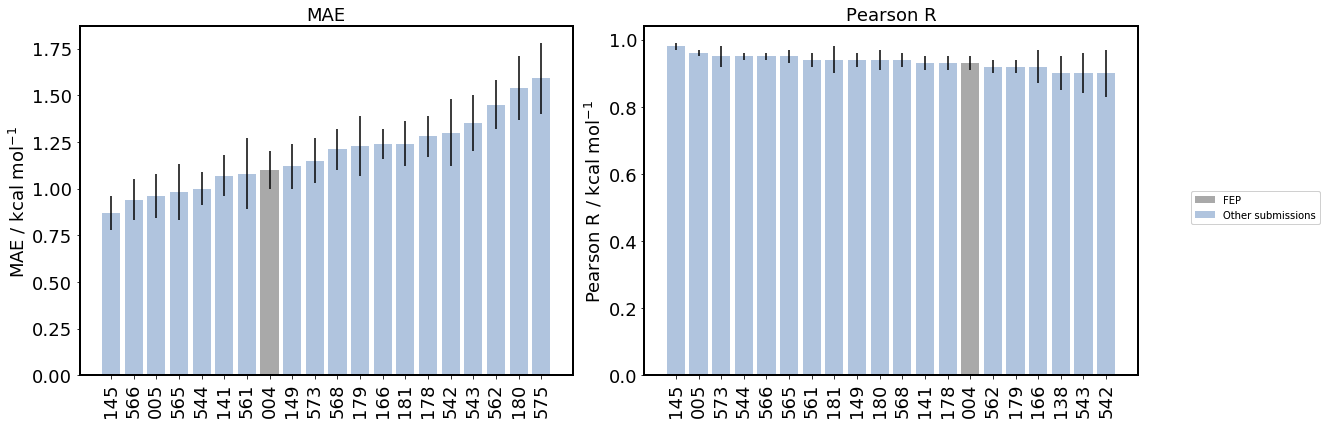

In [35]:
plot_sampl4_bar()

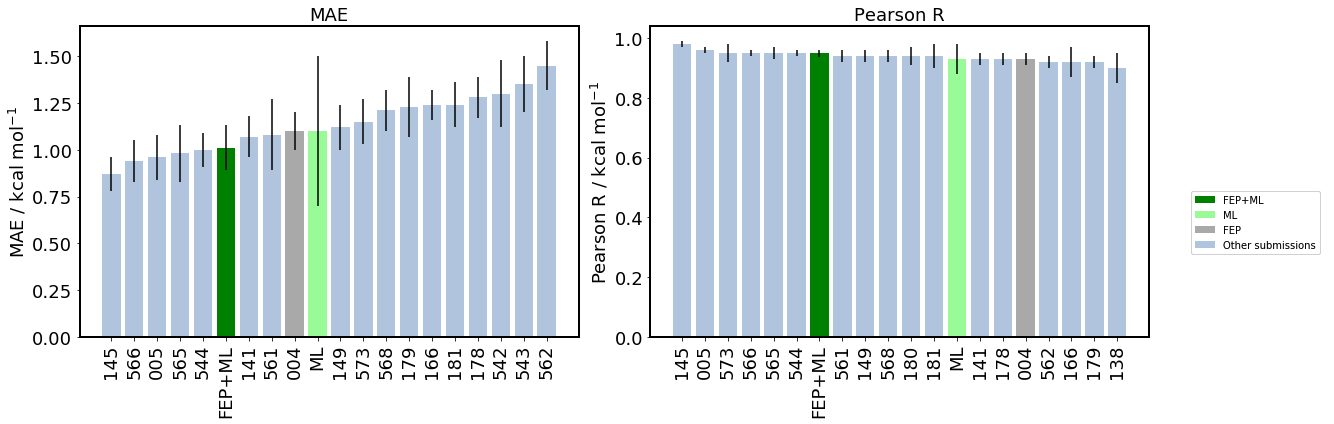

In [36]:
plot_sampl4_bar(fep_ml_df, dnn_df, null_dnn_df)